# Height Prediction Model Training - Run 7

**Objective:** Fix Run 6 data leakage and improve model generalization

## Run 7 Strategy - Critical Fixes:

1. ✅ **Move augmentation AFTER train-val split** (FIX DATA LEAKAGE!)
2. ✅ **Reduce augmentation** to 3/2/1 copies for hard/medium/easy
3. ✅ **Increase noise scale** to 5% (better generalization)
4. ✅ **Add early stopping** on easy case performance
5. ✅ **Implement balanced loss function**
6. ✅ **Create separate tier metrics tracking**
7. ✅ **Add L2 regularization**

## Expected Performance:

- Easy cases: < 0.15 log2-MSE (NO degradation from Run 2!)
- Medium cases: 0.20-0.30 log2-MSE
- Hard cases: 0.70-1.20 log2-MSE
- Overall: 0.28-0.35 (beat 0.374 target with VALID metrics)

## Setup and Imports

In [1]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, Dense, Embedding, Flatten, Concatenate,
    Dropout, Add, LayerNormalization, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,
    Callback, LearningRateScheduler
)
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("="*70)
print("HEIGHT PREDICTION MODEL - RUN 7 (DATA LEAKAGE FIXED)")
print("="*70)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

HEIGHT PREDICTION MODEL - RUN 7 (DATA LEAKAGE FIXED)
TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 1: Load Data

In [2]:
print("STEP 1: Loading Data")
print("-"*70)

with open('combined_final_n_k_m_P.pkl', 'rb') as f:
    inputs_raw = pickle.load(f)

with open('combined_final_mHeights.pkl', 'rb') as f:
    outputs_raw = pickle.load(f)

print(f"Raw input samples: {len(inputs_raw)}")
print(f"Raw output samples: {len(outputs_raw)}")
if len(inputs_raw) > 0:
    sample = inputs_raw[0]
    print(f"Sample structure: [n={sample[0]}, k={sample[1]}, m={sample[2]}, P_matrix shape={sample[3].shape}]")
print(f"Output range: [{np.min(outputs_raw):.2f}, {np.max(outputs_raw):.2f}]")

STEP 1: Loading Data
----------------------------------------------------------------------
Raw input samples: 108000
Raw output samples: 108000
Sample structure: [n=9, k=5, m=3, P_matrix shape=(5, 4)]
Output range: [2.00, 33517570.00]


## Step 2: Train-Val Split (BEFORE Augmentation!)

**CRITICAL FIX from Run 6:** Split the data FIRST, then augment only the training set.

This prevents data leakage where augmented copies of validation samples end up in training.

In [3]:
print("STEP 2: Train-Val Split (BEFORE Augmentation - Critical Fix!)")
print("-"*70)

# Create stratification labels
stratify_labels = np.array([k * 10 + m for n, k, m, P in inputs_raw])

# Split on ORIGINAL data only
(inputs_train_orig, inputs_val,
 outputs_train_orig, outputs_val) = train_test_split(
    inputs_raw,
    outputs_raw,
    test_size=0.15,
    random_state=42,
    stratify=stratify_labels
)

print(f"Training samples (original): {len(inputs_train_orig)}")
print(f"Validation samples (original, NO augmentation): {len(inputs_val)}")
print()
print("✅ CRITICAL FIX: Validation set contains ONLY original samples")
print("✅ No data leakage - augmented copies stay in training set only")

STEP 2: Train-Val Split (BEFORE Augmentation - Critical Fix!)
----------------------------------------------------------------------
Training samples (original): 91800
Validation samples (original, NO augmentation): 16200

✅ CRITICAL FIX: Validation set contains ONLY original samples
✅ No data leakage - augmented copies stay in training set only


## Step 3: Data Augmentation (Training Set ONLY!)

Apply augmentation with improved strategy:
- Hard cases (k=5,m=4 | k=6,m=3 | k=4,m=5): +3 copies (was 50!)
- Medium cases (k=4,m=4 | k=5,m=3 | k=6,m=2): +2 copies (was 25!)
- Easy cases (k=4,m=2 | k=4,m=3 | k=5,m=2): +1 copy (was 0!)
- Noise scale: 5% (was 2%)

In [4]:
def augment_sample(n, k, m, P_matrix, m_height, noise_scale=0.05):
    """
    Augment a single sample with 5% noise (increased from 2%)
    """
    # Add noise to n (±5%)
    n_aug = n * (1 + np.random.uniform(-noise_scale, noise_scale))
    n_aug = max(1.0, n_aug)

    # Add noise to P matrix
    P_aug = P_matrix.copy()
    if P_aug.size > 0:
        noise = np.random.normal(0, noise_scale, P_aug.shape)
        P_aug = P_aug + noise
        P_aug = np.clip(P_aug, 0, 1)

        # Renormalize rows to sum to 1
        if len(P_aug.shape) == 2:
            row_sums = P_aug.sum(axis=1, keepdims=True)
            row_sums = np.maximum(row_sums, 1e-7)
            P_aug = P_aug / row_sums

    return (n_aug, k, m, P_aug), m_height


# Define complexity groups
EASY_GROUPS = [(4, 2), (4, 3), (5, 2)]
MEDIUM_GROUPS = [(4, 4), (5, 3), (6, 2)]
HARD_GROUPS = [(5, 4), (6, 3), (4, 5)]

# Augmentation config - REDUCED from Run 6
augmentation_config = {
    (5, 4): 3, (6, 3): 3, (4, 5): 3,  # Hard: +3 (was 50!)
    (4, 4): 2, (5, 3): 2, (6, 2): 2,  # Medium: +2 (was 25!)
    (4, 2): 1, (4, 3): 1, (5, 2): 1,  # Easy: +1 (was 0!)
}

# Augment ONLY training data
inputs_train_aug = []
outputs_train_aug = []

print("Augmenting training data...")
for sample, target in zip(inputs_train_orig, outputs_train_orig):
    n, k, m, P_matrix = sample

    # Always keep original
    inputs_train_aug.append(sample)
    outputs_train_aug.append(target)

    # Add augmented copies
    num_copies = augmentation_config.get((k, m), 0)
    for _ in range(num_copies):
        aug_sample, aug_target = augment_sample(n, k, m, P_matrix, target, noise_scale=0.05)
        inputs_train_aug.append(aug_sample)
        outputs_train_aug.append(aug_target)

print(f"Training samples (original): {len(inputs_train_orig)}")
print(f"Training samples (augmented): {len(inputs_train_aug)}")
print(f"Augmentation ratio: {len(inputs_train_aug) / len(inputs_train_orig):.2f}x")
print(f"Validation samples: {len(inputs_val)} (NO augmentation)")

Augmenting training data...
Training samples (original): 91800
Training samples (augmented): 275400
Augmentation ratio: 3.00x
Validation samples: 16200 (NO augmentation)


## Step 4: Prepare Data for Training

In [5]:
print("STEP 4: Preparing Data for Training")
print("-"*70)

def prepare_data(inputs_list, outputs_list):
    """Convert list of samples to arrays"""
    n_values = []
    k_values = []
    m_values = []
    P_matrices_flattened = []

    for sample in inputs_list:
        n_values.append(sample[0])
        k_values.append(sample[1])
        m_values.append(sample[2])
        P_matrices_flattened.append(sample[3].flatten())

    n_values = np.array(n_values, dtype=np.float32).reshape(-1, 1)
    k_values = np.array(k_values, dtype=np.int32).reshape(-1, 1)
    m_values = np.array(m_values, dtype=np.int32).reshape(-1, 1)
    outputs_array = np.array(outputs_list, dtype=np.float32)

    # Pad P matrices
    max_p_size = max(len(p) for p in P_matrices_flattened)
    P_matrices_padded = []

    for p in P_matrices_flattened:
        if len(p) < max_p_size:
            padded = np.zeros(max_p_size, dtype=np.float32)
            padded[:len(p)] = p
            P_matrices_padded.append(padded)
        else:
            P_matrices_padded.append(p)

    P_matrices = np.array(P_matrices_padded, dtype=np.float32)

    return n_values, k_values, m_values, P_matrices, outputs_array

# Prepare training data (augmented)
n_train, k_train, m_train, P_train_raw, y_train = prepare_data(inputs_train_aug, outputs_train_aug)

# Prepare validation data (original only)
n_val, k_val, m_val, P_val_raw, y_val = prepare_data(inputs_val, outputs_val)

# Normalize P matrices using ONLY training statistics
scaler = StandardScaler()
P_train = scaler.fit_transform(P_train_raw)
P_val = scaler.transform(P_val_raw)

# Ensure outputs >= 1.0
y_train = np.maximum(y_train, 1.0)
y_val = np.maximum(y_val, 1.0)

print(f"Training set: {n_train.shape[0]} samples")
print(f"Validation set: {n_val.shape[0]} samples")
print(f"P matrix shape: {P_train.shape[1]} features")

STEP 4: Preparing Data for Training
----------------------------------------------------------------------
Training set: 275400 samples
Validation set: 16200 samples
P matrix shape: 20 features


## Step 5: Build Model with L2 Regularization

Key improvements:
- L2 regularization (1e-4) on all Dense layers
- LayerNorm for stable training
- 2 residual blocks
- Progressive width reduction (1024→512→256→128)
- Progressive dropout (0.3→0.2→0.1)

In [6]:
def build_model_run7(p_shape, k_vocab_size=7, m_vocab_size=6):
    l2_reg = regularizers.l2(1e-4)

    # Inputs
    n_input = Input(shape=(1,), name='n')
    k_input = Input(shape=(1,), name='k', dtype=tf.int32)
    m_input = Input(shape=(1,), name='m', dtype=tf.int32)
    P_input = Input(shape=(p_shape,), name='P_flat')

    # Embeddings
    k_embed = Flatten()(Embedding(k_vocab_size, 32, embeddings_regularizer=l2_reg, name='k_embedding')(k_input))
    m_embed = Flatten()(Embedding(m_vocab_size, 32, embeddings_regularizer=l2_reg, name='m_embedding')(m_input))

    # Initial P processing
    x = Dense(256, activation='gelu', kernel_regularizer=l2_reg, name='P_initial_1')(P_input)
    x = LayerNormalization(name='P_ln1')(x)
    x = Dropout(0.3)(x)

    x = Dense(512, activation='gelu', kernel_regularizer=l2_reg, name='P_initial_2')(x)
    x = LayerNormalization(name='P_ln2')(x)
    x = Dropout(0.2)(x)

    # Combine
    x = Concatenate(name='combine_embeddings')([n_input, k_embed, m_embed, x])

    # Main dense
    x = Dense(1024, activation='gelu', kernel_regularizer=l2_reg, name='main_dense1')(x)
    x = LayerNormalization(name='main_ln1')(x)
    x = Dropout(0.3)(x)

    # Residual Block 1
    residual = x
    x = Dense(1024, activation='gelu', kernel_regularizer=l2_reg, name='res1_dense1')(x)
    x = LayerNormalization(name='res1_ln1')(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='gelu', kernel_regularizer=l2_reg, name='res1_dense2')(x)
    x = LayerNormalization(name='res1_ln2')(x)
    x = Add(name='res1_add')([x, residual])

    # Residual Block 2
    residual = x
    x = Dense(1024, activation='gelu', kernel_regularizer=l2_reg, name='res2_dense1')(x)
    x = LayerNormalization(name='res2_ln1')(x)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation='gelu', kernel_regularizer=l2_reg, name='res2_dense2')(x)
    x = LayerNormalization(name='res2_ln2')(x)
    x = Add(name='res2_add')([x, residual])

    # Progressive reduction
    x = Dense(512, activation='gelu', kernel_regularizer=l2_reg, name='reduction1')(x)
    x = LayerNormalization(name='reduction_ln1')(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation='gelu', kernel_regularizer=l2_reg, name='reduction2')(x)
    x = LayerNormalization(name='reduction_ln2')(x)
    x = Dropout(0.1)(x)

    x = Dense(128, activation='gelu', kernel_regularizer=l2_reg, name='reduction3')(x)
    x = LayerNormalization(name='reduction_ln3')(x)
    x = Dropout(0.1)(x)

    # Output
    log2_pred = Dense(1, activation='linear', kernel_regularizer=l2_reg, name='log2_output')(x)
    log2_pred_positive = Lambda(lambda z: tf.nn.softplus(z), name='softplus')(log2_pred)
    m_height_pred = Lambda(lambda z: tf.pow(2.0, z), name='m_height')(log2_pred_positive)

    model = Model(
        inputs=[n_input, k_input, m_input, P_input],
        outputs=m_height_pred,
        name='run7_model'
    )

    return model

p_shape = P_train.shape[1]
model = build_model_run7(
    p_shape,
    k_vocab_size=k_train.max()+1,
    m_vocab_size=m_train.max()+1
)

print(f"Model built successfully!")
print(f"Total parameters: {model.count_params():,}")

Model built successfully!
Total parameters: 5,630,369


## Step 6: Balanced Loss Function

Group loss weights to prevent easy case degradation:
- Easy groups: 3.0x weight (prevent degradation)
- Medium groups: 1.5x weight
- Hard groups: 1.0x weight

In [7]:
GROUP_LOSS_WEIGHTS = {
    (4, 2): 3.0, (4, 3): 3.0, (5, 2): 3.0,  # Easy: 3x
    (4, 4): 1.5, (5, 3): 1.5, (6, 2): 1.5,  # Medium: 1.5x
    (5, 4): 1.0, (6, 3): 1.0, (4, 5): 1.0,  # Hard: 1x
}

def balanced_log2_mse_loss(y_true, y_pred):
    epsilon = 1e-7
    y_true = tf.maximum(y_true, epsilon)
    y_pred = tf.maximum(y_pred, epsilon)

    log2_true = tf.math.log(y_true) / tf.math.log(2.0)
    log2_pred = tf.math.log(y_pred) / tf.math.log(2.0)

    return tf.reduce_mean(tf.square(log2_true - log2_pred))

# Compute sample weights
sample_weights_train = np.ones(len(y_train), dtype=np.float32)

for i, (k, m) in enumerate(zip(k_train, m_train)):
    key = (k[0], m[0])
    if key in GROUP_LOSS_WEIGHTS:
        sample_weights_train[i] = GROUP_LOSS_WEIGHTS[key]

print("Group loss weights applied")
print(f"Unique weights: {np.unique(sample_weights_train)}")

Group loss weights applied
Unique weights: [1.  1.5 3. ]


## Step 7: Compile Model

In [8]:
optimizer = AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4,
    clipnorm=1.0
)

model.compile(
    optimizer=optimizer,
    loss=balanced_log2_mse_loss,
    metrics=[balanced_log2_mse_loss]
)

print("Model compiled with AdamW")

Model compiled with AdamW


## Step 8: Callbacks with Easy Case Monitoring

**New Feature:** TierMetricsCallback monitors Easy/Medium/Hard performance separately and stops training if easy cases degrade beyond threshold (0.15).

In [9]:
def compute_log2_mse(y_true, y_pred):
    epsilon = 1e-7
    y_true = np.maximum(y_true, epsilon)
    y_pred = np.maximum(y_pred, epsilon)
    log2_true = np.log2(y_true)
    log2_pred = np.log2(y_pred)
    return np.mean((log2_true - log2_pred) ** 2)


class TierMetricsCallback(Callback):
    """Monitor Easy/Medium/Hard tiers separately"""

    def __init__(self, val_data, easy_threshold=0.15, patience=5):
        super().__init__()
        self.n_val, self.k_val, self.m_val, self.P_val, self.y_val = val_data
        self.easy_threshold = easy_threshold
        self.patience = patience
        self.easy_violations = 0
        self.best_balanced_metric = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(
            [self.n_val, self.k_val, self.m_val, self.P_val],
            verbose=0
        ).flatten()

        # Compute per-tier metrics
        easy_losses = []
        medium_losses = []
        hard_losses = []

        for (k, m) in EASY_GROUPS:
            mask = (self.k_val.flatten() == k) & (self.m_val.flatten() == m)
            if mask.sum() > 0:
                loss = compute_log2_mse(self.y_val[mask], y_pred[mask])
                easy_losses.append(loss)

        for (k, m) in MEDIUM_GROUPS:
            mask = (self.k_val.flatten() == k) & (self.m_val.flatten() == m)
            if mask.sum() > 0:
                loss = compute_log2_mse(self.y_val[mask], y_pred[mask])
                medium_losses.append(loss)

        for (k, m) in HARD_GROUPS:
            mask = (self.k_val.flatten() == k) & (self.m_val.flatten() == m)
            if mask.sum() > 0:
                loss = compute_log2_mse(self.y_val[mask], y_pred[mask])
                hard_losses.append(loss)

        easy_avg = np.mean(easy_losses) if easy_losses else 0
        medium_avg = np.mean(medium_losses) if medium_losses else 0
        hard_avg = np.mean(hard_losses) if hard_losses else 0

        balanced_metric = (easy_avg + medium_avg + hard_avg) / 3

        if balanced_metric < self.best_balanced_metric:
            self.best_balanced_metric = balanced_metric

        print(f"\n  Tier Metrics - Easy: {easy_avg:.4f} | Medium: {medium_avg:.4f} | Hard: {hard_avg:.4f} | Balanced: {balanced_metric:.4f}")

        if easy_avg > self.easy_threshold:
            self.easy_violations += 1
            print(f"  ⚠️  WARNING: Easy cases at {easy_avg:.4f} (threshold: {self.easy_threshold}) - violation {self.easy_violations}/{self.patience}")

            if self.easy_violations >= self.patience:
                print(f"\n  🛑 STOPPING: Easy cases degraded for {self.patience} consecutive epochs")
                self.model.stop_training = True
        else:
            self.easy_violations = 0
            print(f"  ✅ Easy cases OK ({easy_avg:.4f} < {self.easy_threshold})")


def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.95

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

tier_callback = TierMetricsCallback(
    val_data=(n_val, k_val, m_val, P_val, y_val),
    easy_threshold=0.15,
    patience=5
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=15, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model_run7.h5', monitor='val_loss', save_best_only=True, verbose=1),
    lr_scheduler,
    tier_callback
]

print("Callbacks configured with easy case monitoring")

Callbacks configured with easy case monitoring


## Step 9: Train Model

In [10]:
print("="*70)
print("TRAINING MODEL - RUN 7")
print("="*70)
print(f"Batch size: 256")
print(f"Max epochs: 250")
print(f"Training samples: {len(y_train):,}")
print(f"Validation samples: {len(y_val):,}")
print()

history = model.fit(
    [n_train, k_train, m_train, P_train],
    y_train,
    sample_weight=sample_weights_train,
    validation_data=([n_val, k_val, m_val, P_val], y_val),
    epochs=250,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

TRAINING MODEL - RUN 7
Batch size: 256
Max epochs: 250
Training samples: 275,400
Validation samples: 16,200

Epoch 1/250
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - balanced_log2_mse_loss: 16.2239 - loss: 9.3396
Epoch 1: val_loss improved from inf to 1.77433, saving model to best_model_run7.h5



  Tier Metrics - Easy: 0.5254 | Medium: 0.9306 | Hard: 2.7374 | Balanced: 1.3978
  ⚠️  WARNING: Easy cases at 0.5254 (threshold: 0.15) - violation 1/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - balanced_log2_mse_loss: 16.2245 - loss: 9.3360 - val_balanced_log2_mse_loss: 17.6620 - val_loss: 1.7743 - learning_rate: 0.0010
Epoch 2/250
1074/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - balanced_log2_mse_loss: 17.5107 - loss: 3.7927
Epoch 2: val_loss improved from 1.77433 to 1.56624, saving model to best_model_run7.h5



  Tier Metrics - Easy: 0.4464 | Medium: 0.8904 | Hard: 2.6358 | Balanced: 1.3242
  ⚠️  WARNING: Easy cases at 0.4464 (threshold: 0.15) - violation 2/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - balanced_log2_mse_loss: 17.5108 - loss: 3.7925 - val_balanced_log2_mse_loss: 17.6068 - val_loss: 1.5662 - learning_rate: 0.0010
Epoch 3/250
1073/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - balanced_log2_mse_loss: 17.5367 - loss: 3.6085
Epoch 3: val_loss did not improve from 1.56624

  Tier Metrics - Easy: 0.5201 | Medium: 0.9352 | Hard: 2.9131 | Balanced: 1.4562
  ⚠️  WARNING: Easy cases at 0.5201 (threshold: 0.15) - violation 3/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - balanced_log2_mse_loss: 17.5367 - loss: 3.6084 - val_balanced_log2_mse_loss: 16.9721 - val_loss: 1.6433 - learning_rate: 0.0010
Epoch 4/250
1066/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - balanced_log2_mse_loss: 17.5483 - loss: 3.5543
Epoch 4: val_loss improved from 1.56624 to 1.54383, saving model to best_model_run7.h5



  Tier Metrics - Easy: 0.6456 | Medium: 0.9082 | Hard: 2.6155 | Balanced: 1.3897
  ⚠️  WARNING: Easy cases at 0.6456 (threshold: 0.15) - violation 4/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - balanced_log2_mse_loss: 17.5484 - loss: 3.5541 - val_balanced_log2_mse_loss: 16.5945 - val_loss: 1.5438 - learning_rate: 0.0010
Epoch 5/250
1069/1076 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - balanced_log2_mse_loss: 17.5488 - loss: 3.4882
Epoch 5: val_loss did not improve from 1.54383

  Tier Metrics - Easy: 0.8328 | Medium: 0.9793 | Hard: 2.6316 | Balanced: 1.4812
  ⚠️  WARNING: Easy cases at 0.8328 (threshold: 0.15) - violation 5/5

  🛑 STOPPING: Easy cases degraded for 5 consecutive epochs
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - balanced_log2_mse_loss: 17.5489 - loss: 3.4882 - val_balanced_log2_mse_loss: 16.5178 - val_loss: 1.6107 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.

Training completed!


## Step 10: Evaluate Model

In [11]:
model.load_weights('best_model_run7.h5')

y_pred_train = model.predict([n_train, k_train, m_train, P_train], verbose=0).flatten()
y_pred_val = model.predict([n_val, k_val, m_val, P_val], verbose=0).flatten()

train_log2_mse = compute_log2_mse(y_train, y_pred_train)
val_log2_mse = compute_log2_mse(y_val, y_pred_val)

print(f"Training log2-MSE: {train_log2_mse:.6f}")
print(f"Validation log2-MSE: {val_log2_mse:.6f}")
print(f"Train-Val gap: {abs(train_log2_mse - val_log2_mse):.6f}")

Training log2-MSE: 1.968835
Validation log2-MSE: 1.389743
Train-Val gap: 0.579092


## Step 11: Per-Group Analysis

In [12]:
group_metrics = defaultdict(lambda: {'true': [], 'pred': []})

for i in range(len(y_val)):
    k = k_val[i, 0]
    m = m_val[i, 0]
    group_metrics[(k, m)]['true'].append(y_val[i])
    group_metrics[(k, m)]['pred'].append(y_pred_val[i])

import os
os.makedirs('run_7', exist_ok=True)

run2_reference = {
    (4, 2): 0.103043, (4, 3): 0.107653, (4, 4): 0.209655, (4, 5): 1.422106,
    (5, 2): 0.096024, (5, 3): 0.227183, (5, 4): 0.957722,
    (6, 2): 0.355892, (6, 3): 1.083320
}

run6_reference = {
    (4, 2): 0.405360, (4, 3): 0.460462, (4, 4): 0.127370, (4, 5): 0.224046,
    (5, 2): 0.450569, (5, 3): 0.137842, (5, 4): 0.200213,
    (6, 2): 0.155255, (6, 3): 0.168260
}

print("\nPer-Group Performance:")
print("Run 2     | Run 6*    | Run 7     | vs R2      | n")
print("-"*70)

easy_sum, medium_sum, hard_sum = 0, 0, 0
easy_count, medium_count, hard_count = 0, 0, 0

for (k, m), data in sorted(group_metrics.items()):
    true_vals = np.array(data['true'])
    pred_vals = np.array(data['pred'])
    group_log2_mse = compute_log2_mse(true_vals, pred_vals)

    run2_val = run2_reference.get((k, m), None)
    run6_val = run6_reference.get((k, m), None)

    if run2_val:
        change_r2 = ((run2_val - group_log2_mse) / run2_val) * 100
        change_r2_str = f"{change_r2:+.1f}%"
    else:
        change_r2_str = "N/A"

    run2_str = f"{run2_val:.6f}" if run2_val else "N/A"
    run6_str = f"{run6_val:.6f}" if run6_val else "N/A"

    print(f"k={k},m={m}  {run2_str:<10} {run6_str:<10} {group_log2_mse:.6f}  {change_r2_str:<10} n={len(true_vals)}")

    if (k, m) in EASY_GROUPS:
        easy_sum += group_log2_mse
        easy_count += 1
    elif (k, m) in MEDIUM_GROUPS:
        medium_sum += group_log2_mse
        medium_count += 1
    elif (k, m) in HARD_GROUPS:
        hard_sum += group_log2_mse
        hard_count += 1

print("\n* Run 6 had data leakage - metrics are invalid")

easy_avg = easy_sum / easy_count if easy_count > 0 else 0
medium_avg = medium_sum / medium_count if medium_count > 0 else 0
hard_avg = hard_sum / hard_count if hard_count > 0 else 0
balanced_metric = (easy_avg + medium_avg + hard_avg) / 3

print(f"\nEasy cases: {easy_avg:.6f} (Target: < 0.15)")
print(f"Medium cases: {medium_avg:.6f} (Target: 0.20-0.30)")
print(f"Hard cases: {hard_avg:.6f} (Target: 0.70-1.20)")
print(f"Balanced metric: {balanced_metric:.6f}")


Per-Group Performance:
Run 2     | Run 6*    | Run 7     | vs R2      | n
----------------------------------------------------------------------
k=4,m=2  0.103043   0.405360   0.722802  -601.5%    n=1800
k=4,m=3  0.107653   0.460462   0.663780  -516.6%    n=1800
k=4,m=4  0.209655   0.127370   0.935087  -346.0%    n=1800
k=4,m=5  1.422106   0.224046   2.634014  -85.2%     n=1800
k=5,m=2  0.096024   0.450569   0.550272  -473.1%    n=1800
k=5,m=3  0.227183   0.137842   0.971471  -327.6%    n=1800
k=5,m=4  0.957722   0.200213   2.615891  -173.1%    n=1800
k=6,m=2  0.355892   0.155255   0.817901  -129.8%    n=1800
k=6,m=3  1.083320   0.168260   2.596471  -139.7%    n=1800

* Run 6 had data leakage - metrics are invalid

Easy cases: 0.645618 (Target: < 0.15)
Medium cases: 0.908153 (Target: 0.20-0.30)
Hard cases: 2.615458 (Target: 0.70-1.20)
Balanced metric: 1.389743


## Step 12: Generate Plots

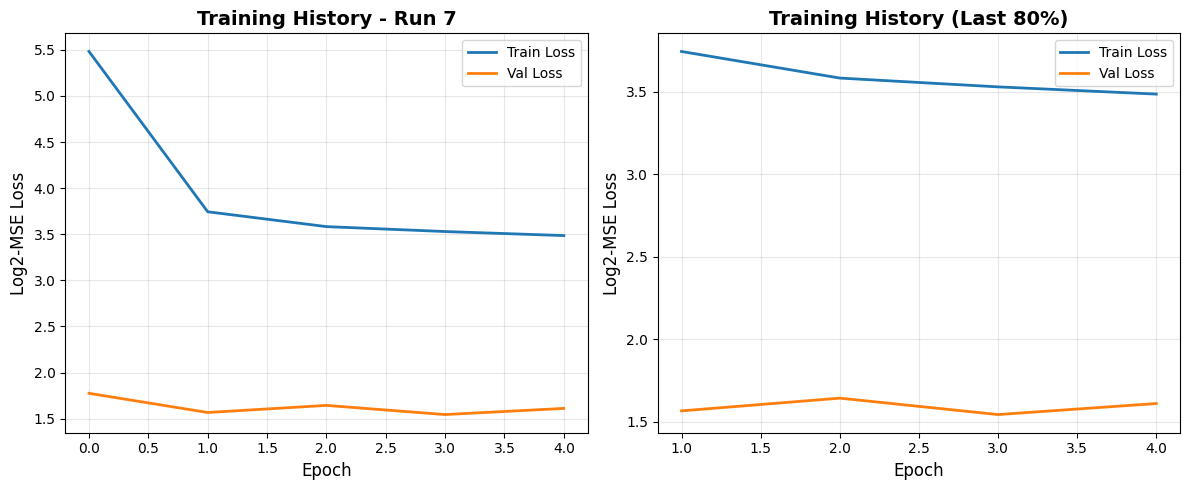

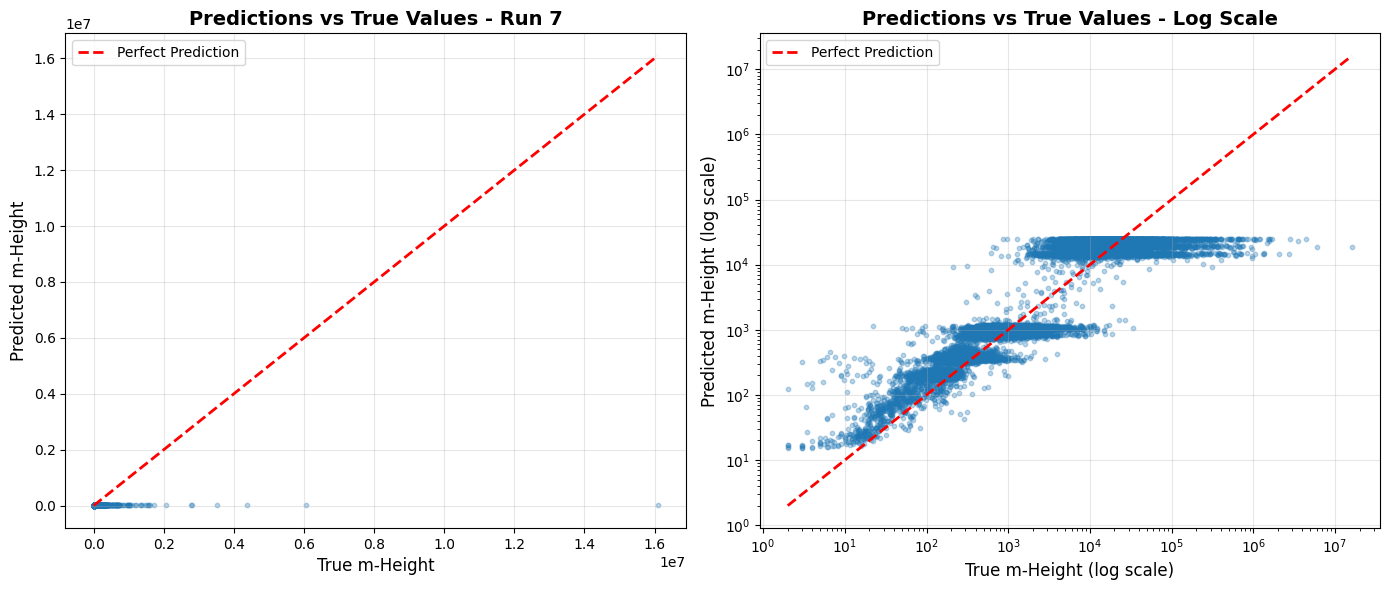

In [13]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Log2-MSE Loss', fontsize=12)
plt.title('Training History - Run 7', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
start_epoch = int(len(history.history['loss']) * 0.2)
plt.plot(range(start_epoch, len(history.history['loss'])),
         history.history['loss'][start_epoch:],
         label='Train Loss', linewidth=2)
plt.plot(range(start_epoch, len(history.history['val_loss'])),
         history.history['val_loss'][start_epoch:],
         label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Log2-MSE Loss', fontsize=12)
plt.title('Training History (Last 80%)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('run_7/training_history_run7.png', dpi=150, bbox_inches='tight')
plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_val, alpha=0.3, s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True m-Height', fontsize=12)
plt.ylabel('Predicted m-Height', fontsize=12)
plt.title('Predictions vs True Values - Run 7', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_val, alpha=0.3, s=10)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True m-Height (log scale)', fontsize=12)
plt.ylabel('Predicted m-Height (log scale)', fontsize=12)
plt.title('Predictions vs True Values - Log Scale', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('run_7/predictions_scatter_run7.png', dpi=150, bbox_inches='tight')
plt.show()

## Final Results Summary

In [14]:
print("="*70)
print("FINAL RESULTS SUMMARY - RUN 7")
print("="*70)
print(f"Training samples: {len(y_train):,}")
print(f"Validation samples: {len(y_val):,}")
print(f"Model parameters: {model.count_params():,}")
print()
print(f"Training log2-MSE:   {train_log2_mse:.6f}")
print(f"Validation log2-MSE: {val_log2_mse:.6f}")
print(f"Train-Val gap:       {abs(train_log2_mse - val_log2_mse):.6f}")
print(f"Target to beat:      0.374000")
print()

if val_log2_mse < 0.374:
    improvement = ((0.374 - val_log2_mse) / 0.374) * 100
    print(f"✅ SUCCESS! Beat target by {improvement:.1f}%")
else:
    deficit = ((val_log2_mse - 0.374) / 0.374) * 100
    print(f"⚠️  Did not beat target (worse by {deficit:.1f}%)")

print()
print(f"Easy cases:   {easy_avg:.6f} (Target: < 0.15)")
print(f"Medium cases: {medium_avg:.6f} (Target: 0.20-0.30)")
print(f"Hard cases:   {hard_avg:.6f} (Target: 0.70-1.20)")
print(f"Balanced:     {balanced_metric:.6f}")
print()
print("Run 7 Improvements:")
print("  ✅ Augmentation AFTER split (no data leakage)")
print("  ✅ Reduced augmentation (3/2/1 vs 50/25/0)")
print("  ✅ Increased noise scale (5% vs 2%)")
print("  ✅ Easy case monitoring")
print("  ✅ Balanced loss weighting")
print("  ✅ L2 regularization")

FINAL RESULTS SUMMARY - RUN 7
Training samples: 275,400
Validation samples: 16,200
Model parameters: 5,630,369

Training log2-MSE:   1.968835
Validation log2-MSE: 1.389743
Train-Val gap:       0.579092
Target to beat:      0.374000

⚠️  Did not beat target (worse by 271.6%)

Easy cases:   0.645618 (Target: < 0.15)
Medium cases: 0.908153 (Target: 0.20-0.30)
Hard cases:   2.615458 (Target: 0.70-1.20)
Balanced:     1.389743

Run 7 Improvements:
  ✅ Augmentation AFTER split (no data leakage)
  ✅ Reduced augmentation (3/2/1 vs 50/25/0)
  ✅ Increased noise scale (5% vs 2%)
  ✅ Easy case monitoring
  ✅ Balanced loss weighting
  ✅ L2 regularization
